<a href="https://colab.research.google.com/github/dexter11235813/EVA_5/blob/main/assignment_3/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Dec 12 15:10:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import partial
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=3, bias=False)
    self.conv2 = nn.Conv2d(10, 10, kernel_size=3, bias=False)
    self.conv3 = nn.Conv2d(10, 20, kernel_size=3, bias=False)
    self.conv4 = nn.Conv2d(20, 20, kernel_size=3, bias=False)
    self.conv5 = nn.Conv2d(20, 30, kernel_size=3, bias=False)
    self.max_pool = nn.MaxPool2d(2,2)
    self.conv6 = nn.Conv2d(30, 62, kernel_size=3, bias=False)
    self.GAP = nn.AvgPool2d(4)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    
  def forward(self, x):
    x = self.max_pool(self.dropout(self.relu(self.conv2(self.dropout(self.relu(self.conv1(x)))))))
    x = self.dropout(self.relu(self.conv4(self.dropout(self.relu(self.conv3(x))))))
    x = self.relu(self.conv5(x))
    x = self.GAP(self.conv6(x))
    #x = x.view(-1, 10)
    #print(x.shape)
    return F.log_softmax(x.view(-1, 62), dim=1) 

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
           Dropout-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
           Dropout-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 20, 10, 10]           1,800
              ReLU-9           [-1, 20, 10, 10]               0
          Dropout-10           [-1, 20, 10, 10]               0
           Conv2d-11             [-1, 20, 8, 8]           3,600
             ReLU-12             [-1, 20, 8, 8]               0
          Dropout-13             [-1, 20, 8, 8]               0
           Conv2d-14             [-1, 3

In [ ]:
train_set = datasets.EMNIST(
    root="./data",
    train=True,
    download=True,
    split="byclass",
    transform=transforms.Compose(
        [
            # transforms.RandomRotation(10),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
test_set = datasets.EMNIST(
    root="./data",
    train=False,
    download=True,
    split="byclass",
    transform=transforms.Compose(
        [
            # transforms.RandomRotation(10),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ]
    ),
)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

tensor([ 5, 39,  6, 55,  2,  5,  4,  2,  8,  2, 30,  0, 53,  4, 20, 21,  3,  3,
        52,  4,  2, 53,  2,  2,  1, 30, 53, 11,  5, 36,  6,  0])


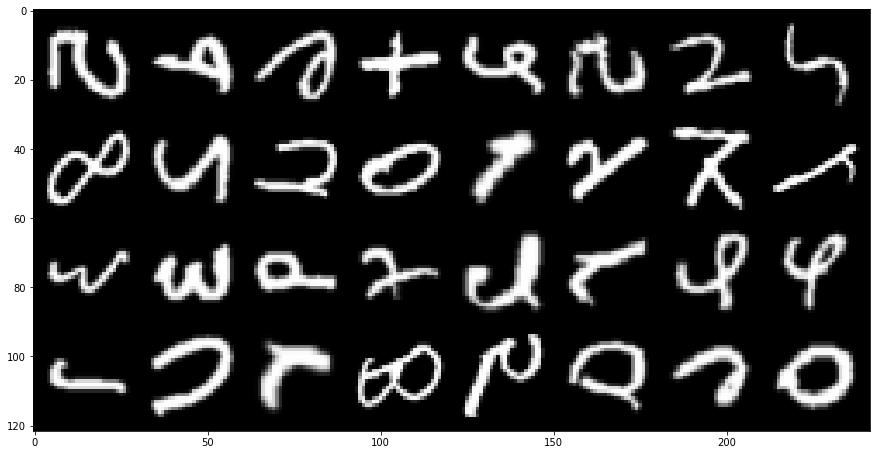

In [ ]:
batch = next(iter(train_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))
print(labels)


In [ ]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for _, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)
        loss.backward()
        optimizer.step()


# pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output.squeeze(), target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )



In [ ]:

optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    print(f'EPOCH {epoch} / 10')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 10/21811 [00:00<03:42, 98.18it/s]

EPOCH 0 / 10


  0%|          | 12/21811 [00:00<03:09, 115.19it/s]


Test set: Average loss: 0.0148, Accuracy: 97123/116323 (83%)

EPOCH 1 / 10


  0%|          | 12/21811 [00:00<03:07, 115.99it/s]


Test set: Average loss: 0.0141, Accuracy: 97863/116323 (84%)

EPOCH 2 / 10


  0%|          | 10/21811 [00:00<03:42, 97.85it/s]


Test set: Average loss: 0.0135, Accuracy: 98517/116323 (85%)

EPOCH 3 / 10


  0%|          | 11/21811 [00:00<03:28, 104.76it/s]


Test set: Average loss: 0.0133, Accuracy: 99021/116323 (85%)

EPOCH 4 / 10


  0%|          | 8/21811 [00:00<04:37, 78.45it/s]


Test set: Average loss: 0.0132, Accuracy: 99068/116323 (85%)

EPOCH 5 / 10


  0%|          | 11/21811 [00:00<03:26, 105.49it/s]


Test set: Average loss: 0.0128, Accuracy: 99600/116323 (86%)

EPOCH 6 / 10


  0%|          | 10/21811 [00:00<03:40, 98.89it/s]


Test set: Average loss: 0.0129, Accuracy: 99574/116323 (86%)

EPOCH 7 / 10


  0%|          | 9/21811 [00:00<04:14, 85.79it/s]


Test set: Average loss: 0.0128, Accuracy: 99536/116323 (86%)

EPOCH 8 / 10


  0%|          | 10/21811 [00:00<03:41, 98.52it/s]


Test set: Average loss: 0.0133, Accuracy: 99529/116323 (86%)

EPOCH 9 / 10


100%|██████████| 3636/3636 [00:12<00:00, 282.28it/s]


Test set: Average loss: 0.0128, Accuracy: 99392/116323 (85%)

